# Image Classification with HOG Feature and SVM

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from skimage.feature import hog
from sklearn.utils import shuffle

## 1. Dataset Preparation

**Konfigurasi visualisasi**

In [8]:
sns.set(style="whitegrid")
plt.rcParams["figure.dpi"] = 100

**Membaca file CSV / Load data image**

In [21]:
train_df = pd.read_csv('emnist-letters-train.csv', header=None)
test_df = pd.read_csv('emnist-letters-test.csv', header=None)

In [22]:
print(train_df.head())
print(train_df.columns)


   0    1    2    3    4    5    6    7    8    9    ...  775  776  777  778  \
0   23    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
1    7    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
2   16    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
3   15    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
4   23    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   

   779  780  781  782  783  784  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4    0    0    0    0    0    0  

[5 rows x 785 columns]
Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            775, 776, 777, 778, 779, 780, 781, 782, 783, 784],
           dtype='int64', length=785)


**Data training dan testing digabung menjadi satu dataframe**


In [24]:
data = pd.concat([train_df, test_df], ignore_index=True)

**Shuffle Data**
**Mengacak urutan data agar distribusi kelas acak saat pemrosesan**

In [17]:
data = shuffle(data, random_state=42)

**Balance Data**
**Mengambil tepat 100 contoh dari setiap kelas (1 sampai 26) agar dataset seimbang**

In [26]:
print(data.columns)

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            775, 776, 777, 778, 779, 780, 781, 782, 783, 784],
           dtype='int64', length=785)


In [27]:
samples_per_class = 100
balanced_data = pd.concat([
    data[data[0] == i].iloc[:samples_per_class] for i in range(1, 27)
], ignore_index=True)


**Memisahkan label dan fitur gambar**
**Gambar diubah bentuknya menjadi 28x28 pixel untuk keperluan visualisasi dan ekstraksi fitur**

In [28]:
y = balanced_data.iloc[:, 0].values
X = balanced_data.iloc[:, 1:].values.reshape(-1, 28, 28)

**Visualize Some Samples**
**Menampilkan 26 gambar pertama dari dataset dengan label huruf untuk verifikasi data**

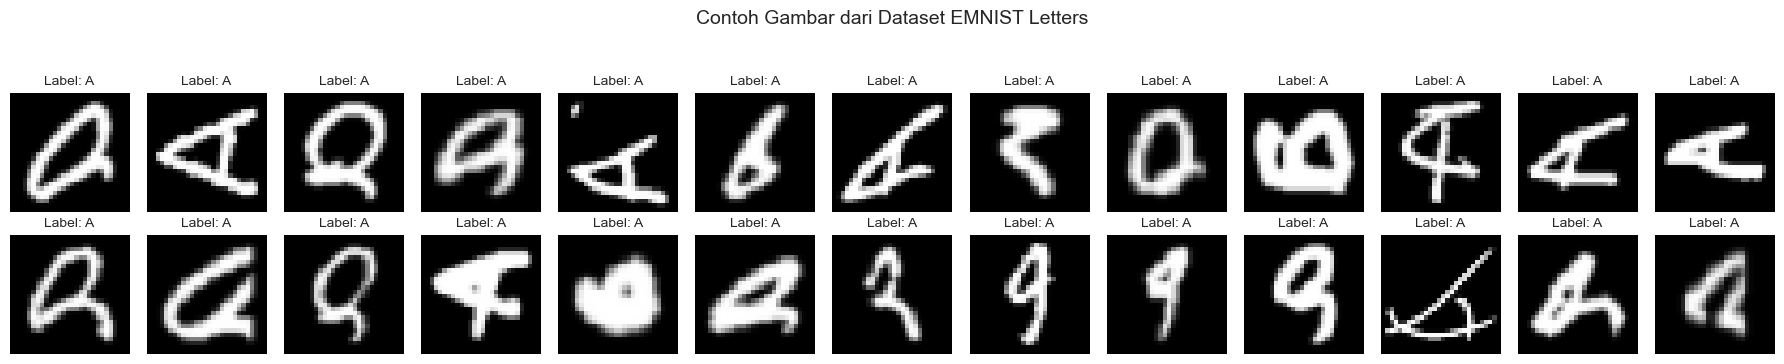

In [29]:
fig, axes = plt.subplots(2, 13, figsize=(18, 4))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(X[i], cmap='gray')
    ax.set_title(f"Label: {chr(y[i] + 64)}", fontsize=10)  # Konversi 1–26 ke A–Z
    ax.axis('off')
plt.suptitle("Contoh Gambar dari Dataset EMNIST Letters", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## 2. Feature Extraction

**Test extract HOG feature from image**

In [30]:
# Parameter HOG disesuaikan untuk mendapatkan representasi yang baik.
def extract_hog_features(images):
    hog_features = []
    for img in images:
        features = hog(img, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), block_norm='L2-Hys')
        hog_features.append(features)
    return np.array(hog_features)

In [33]:
X_hog = extract_hog_features(X)

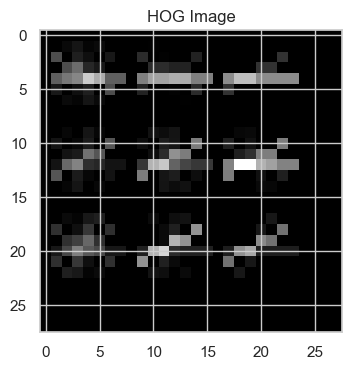

In [41]:
image_data = train_df.iloc[0, 1:].values.reshape(28, 28)  # Asumsi kolom 0 adalah label
feature, hog_image = hog(image_data, orientations=9, pixels_per_cell=(8, 8), 
                         cells_per_block=(2, 2), visualize=True, block_norm='L2')

# Tampilkan hasil HOG
plt.imshow(hog_image, cmap='gray')
plt.title("HOG Image")
plt.show()

In [39]:
feature.shape

(144,)

<BarContainer object of 144 artists>

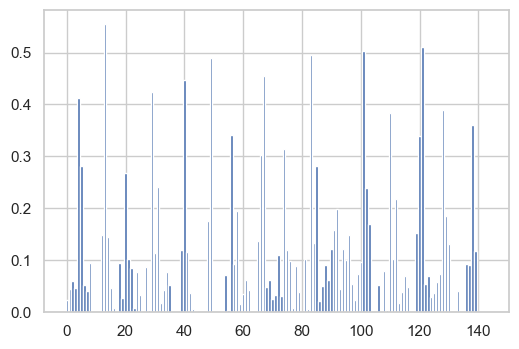

In [42]:
plt.bar(list(range(feature.shape[0])), feature)

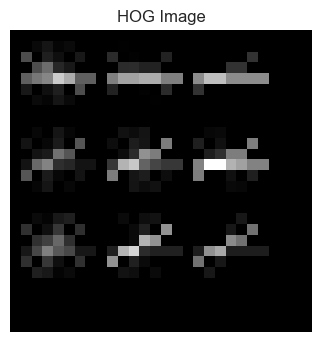

In [44]:
image_array = train_df.iloc[0, 1:].values.reshape(28, 28)

# Hitung HOG
feature, hog_image = hog(image_array,
                         orientations=9,
                         pixels_per_cell=(8, 8),
                         cells_per_block=(2, 2),
                         visualize=True,
                         block_norm='L2')

# Tampilkan hasil HOG
plt.imshow(hog_image, cmap='gray')
plt.title("HOG Image")
plt.axis('off')
plt.show()


<BarContainer object of 144 artists>

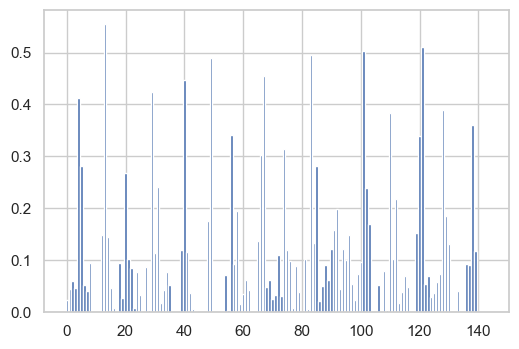

In [45]:
plt.bar(list(range(feature.shape[0])), feature)

## 3. Classification

**Train-Test Split**
**Membagi data menjadi data latih (80%) dan data uji (20%) dengan menjaga proporsi kelas**

In [52]:
X_train, X_test, y_train, y_test = train_test_split(
    X_hog, y, test_size=0.2, random_state=42, stratify=y)

In [53]:
X_train.shape

(2080, 144)

**Menentukan grid parameter untuk model SVM: kernel, C, dan gamma**

**Grid ini akan diuji untuk menemukan kombinasi terbaik**

In [63]:
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.001, 0.01, 0.1],
    'kernel': ['rbf', 'linear']
}

**Melakukan pencarian parameter terbaik dengan GridSearchCV dan validasi**

In [82]:
svc = SVC()
grid = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1],
                         'kernel': ['rbf', 'linear']},
             scoring='accuracy')

**Menampilkan parameter terbaik hasil grid search**

In [83]:
print("Best Parameters:", grid.best_params_)

Best Parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


**Evaluate Best Model Menggunakan model terbaik untuk memprediksi data uji dan mengevaluasi performanya**

In [100]:
y_pred = grid.best_estimator_.predict(X_test)

In [103]:
import pandas as pd

hasil_df = pd.DataFrame({
    'Prediksi': y_pred,
    'Label_Asli': y_test  # Pastikan y_test sudah didefinisikan
})
print(hasil_df.head(10))



   Prediksi  Label_Asli
0         1           1
1         1           1
2         1           1
3         1           1
4        21           1
5         1           1
6         1           1
7        21           1
8         1           1
9         1           1


In [104]:
from sklearn.metrics import accuracy_score

akurasi = accuracy_score(y_test, y_pred)
print(f"Akurasi model: {akurasi:.2f}")

Akurasi model: 0.68


## 4. Evaluation Metrics

### 4.1 Menampilkan metrik evaluasi: precision, recall, f1-score, dan accuracy

In [105]:
Menampilkan metrik evaluasi: precision, recall, f1-score, dan accuracy
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Classification Report:
              precision    recall  f1-score   support

           1       0.54      0.54      0.54       800
           2       0.78      0.49      0.60       800
           3       0.65      0.88      0.75       800
           4       0.79      0.73      0.75       800
           5       0.85      0.65      0.74       800
           6       0.77      0.63      0.69       800
           7       0.71      0.50      0.59       800
           8       0.66      0.76      0.71       800
           9       0.42      0.30      0.35       800
          10       0.86      0.74      0.80       800
          11       0.92      0.77      0.84       800
          12       0.44      0.91      0.60       800
          13       0.86      0.73      0.79       800
          14       0.66      0.75      0.70       800
          15       0.84      0.78      0.81       800
          16       0.85      0.78      0.81       800
          17       0.71      0.53      0.60       800
   

C:\Users\yogaa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yogaa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yogaa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### 4.2 Precission

$$\text { Precision }=\frac{T P}{T P+F P}$$

In [106]:
from sklearn.metrics import precision_score

In [107]:
precision = precision_score(y_test, y_pred, average=None)

In [108]:
precision

array([0.53722084, 0.7833002 , 0.64917127, 0.78513514, 0.85294118,
       0.76586103, 0.71454219, 0.66338798, 0.42429577, 0.86482558,
       0.92238806, 0.44169184, 0.8637037 , 0.66335541, 0.83892617,
       0.85302198, 0.70945946, 0.78133705, 0.7987013 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ])

### 4.3 Recall

$$\text { Recall }=\frac{T P}{T P+F N}$$

In [109]:
from sklearn.metrics import recall_score

In [110]:
recall = recall_score(y_test, y_pred, average=None)

C:\Users\yogaa\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [111]:
recall

array([0.54125, 0.4925 , 0.88125, 0.72625, 0.6525 , 0.63375, 0.4975 ,
       0.75875, 0.30125, 0.74375, 0.7725 , 0.91375, 0.72875, 0.75125,
       0.78125, 0.77625, 0.525  , 0.70125, 0.9225 , 0.     , 0.     ,
       0.     , 0.     , 0.     , 0.     , 0.     ])

### 4.4 Accuracy

$$\text { Accuracy }=\frac{T P+T N}{T P+T N+F P+F N}$$

In [112]:
from sklearn.metrics import accuracy_score

In [113]:
accuracy = accuracy_score(y_test, y_pred)

In [114]:
accuracy

0.6832432432432433

### 4.5 F1-Score

$$\text { F1-Score }=\left(\frac{2}{\text { precision }^{-1}+\text { recall }^{-1}}\right)=2 \cdot\left(\frac{\text { precision } \cdot \text { recall }}{\text { precision }+\text { recall }}\right)$$

In [115]:
from sklearn.metrics import f1_score

In [116]:
f1 = f1_score(y_test, y_pred, average='macro')

In [117]:
f1

0.5106790434716617


# Menampilkan confusion matrix untuk melihat kesalahan prediksi antar kelas.

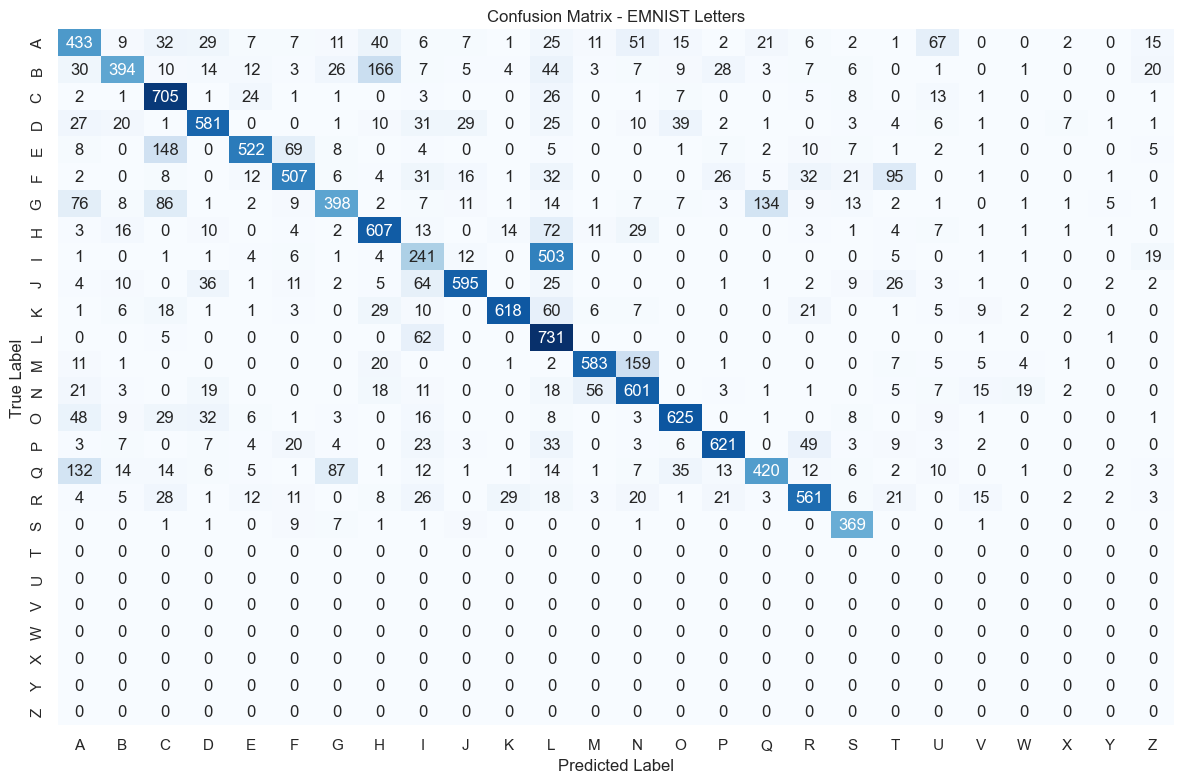

In [118]:
plt.figure(figsize=(12, 8))
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=[chr(i + 64) for i in range(1, 27)],
            yticklabels=[chr(i + 64) for i in range(1, 27)])
plt.title("Confusion Matrix - EMNIST Letters")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()
